## Import Package ,And Load Model

In [17]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt
session = ort.InferenceSession("esrgan.onnx", providers=[ 'CUDAExecutionProvider'])
# session = ort.InferenceSession("esrgan.onnx", providers=[ 'CPUExecutionProvider'])
# session = ort.InferenceSession("esrgan.onnx", providers=[ 'DmlExecutionProvider','CPUExecutionProvider'])

## Define Some Utils Function （From modules/utils.py)

In [18]:
def tensor2img(tensor):
    return (np.squeeze(tensor).clip(0, 1) * 255).astype(np.uint8)        
def imresize_np(img, scale, antialiasing=True):
    # Now the scale should be the same for H and W
    # input: img: Numpy, HWC RBG [0,1]
    # output: HWC RBG [0,1] w/o round
    # (Modified from
    #  https://github.com/open-mmlab/mmsr/blob/master/codes/data/util.py)
    in_H, in_W, in_C = img.shape

    _, out_H, out_W = in_C, np.ceil(in_H * scale), np.ceil(in_W * scale)
    out_H, out_W = out_H.astype(np.int64), out_W.astype(np.int64)
    kernel_width = 4
    kernel = 'cubic'

    # Return the desired dimension order for performing the resize.  The
    # strategy is to perform the resize first along the dimension with the
    # smallest scale factor.
    # Now we do not support this.

    # get weights and indices
    weights_H, indices_H, sym_len_Hs, sym_len_He = _calculate_weights_indices(
        in_H, out_H, scale, kernel, kernel_width, antialiasing)
    weights_W, indices_W, sym_len_Ws, sym_len_We = _calculate_weights_indices(
        in_W, out_W, scale, kernel, kernel_width, antialiasing)
    # process H dimension
    # symmetric copying
    img_aug = np.zeros(((in_H + sym_len_Hs + sym_len_He), in_W, in_C))
    img_aug[sym_len_Hs:sym_len_Hs + in_H] = img

    sym_patch = img[:sym_len_Hs, :, :]
    sym_patch_inv = sym_patch[::-1]
    img_aug[0:sym_len_Hs] = sym_patch_inv

    sym_patch = img[-sym_len_He:, :, :]
    sym_patch_inv = sym_patch[::-1]
    img_aug[sym_len_Hs + in_H:sym_len_Hs + in_H + sym_len_He] = sym_patch_inv

    out_1 = np.zeros((out_H, in_W, in_C))
    kernel_width = weights_H.shape[1]
    for i in range(out_H):
        idx = int(indices_H[i][0])
        out_1[i, :, 0] = weights_H[i].dot(
            img_aug[idx:idx + kernel_width, :, 0].transpose(0, 1))
        out_1[i, :, 1] = weights_H[i].dot(
            img_aug[idx:idx + kernel_width, :, 1].transpose(0, 1))
        out_1[i, :, 2] = weights_H[i].dot(
            img_aug[idx:idx + kernel_width, :, 2].transpose(0, 1))

    # process W dimension
    # symmetric copying
    out_1_aug = np.zeros((out_H, in_W + sym_len_Ws + sym_len_We, in_C))
    out_1_aug[:, sym_len_Ws:sym_len_Ws + in_W] = out_1

    sym_patch = out_1[:, :sym_len_Ws, :]
    sym_patch_inv = sym_patch[:, ::-1]
    out_1_aug[:, 0:sym_len_Ws] = sym_patch_inv

    sym_patch = out_1[:, -sym_len_We:, :]
    sym_patch_inv = sym_patch[:, ::-1]
    out_1_aug[:, sym_len_Ws + in_W:sym_len_Ws + in_W + sym_len_We] = \
        sym_patch_inv

    out_2 = np.zeros((out_H, out_W, in_C))
    kernel_width = weights_W.shape[1]
    for i in range(out_W):
        idx = int(indices_W[i][0])
        out_2[:, i, 0] = out_1_aug[:, idx:idx + kernel_width, 0].dot(
            weights_W[i])
        out_2[:, i, 1] = out_1_aug[:, idx:idx + kernel_width, 1].dot(
            weights_W[i])
        out_2[:, i, 2] = out_1_aug[:, idx:idx + kernel_width, 2].dot(
            weights_W[i])

    return out_2.clip(0, 255)

def create_lr_hr_pair(raw_img, scale=4.):
    lr_h, lr_w = raw_img.shape[0] // scale, raw_img.shape[1] // scale
    hr_h, hr_w = lr_h * scale, lr_w * scale
    hr_img = raw_img[:hr_h, :hr_w, :]
    lr_img = imresize_np(hr_img, 1 / scale)
    return lr_img, hr_img

def _calculate_weights_indices(in_length, out_length, scale, kernel,
                               kernel_width, antialiasing):
    if (scale < 1) and (antialiasing):
        # Use a modified kernel to simultaneously interpolate and antialias
        # larger kernel width
        kernel_width = kernel_width / scale

    # Output-space coordinates
    x = np.linspace(1, out_length, out_length)

    # Input-space coordinates. Calculate the inverse mapping such that 0.5
    # in output space maps to 0.5 in input space, and 0.5+scale in output
    # space maps to 1.5 in input space.
    u = x / scale + 0.5 * (1 - 1 / scale)

    # What is the left-most pixel that can be involved in the computation?
    left = np.floor(u - kernel_width / 2)

    # What is the maximum number of pixels that can be involved in the
    # computation?  Note: it's OK to use an extra pixel here; if the
    # corresponding weights are all zero, it will be eliminated at the end
    # of this function.
    P = (np.ceil(kernel_width) + 2).astype(np.int32)

    # The indices of the input pixels involved in computing the k-th output
    # pixel are in row k of the indices matrix.
    indices = left.reshape(int(out_length), 1).repeat(P, axis=1) + \
        np.linspace(0, P - 1, P).reshape(1, int(P)).repeat(out_length, axis=0)

    # The weights used to compute the k-th output pixel are in row k of the
    # weights matrix.
    distance_to_center = \
        u.reshape(int(out_length), 1).repeat(P, axis=1) - indices
    # apply cubic kernel
    if (scale < 1) and (antialiasing):
        weights = scale * _cubic(distance_to_center * scale)
    else:
        weights = _cubic(distance_to_center)
    # Normalize the weights matrix so that each row sums to 1.
    weights_sum = np.sum(weights, 1).reshape(int(out_length), 1)
    weights = weights / weights_sum.repeat(P, axis=1)

    # If a column in weights is all zero, get rid of it. only consider the
    # first and last column.
    weights_zero_tmp = np.sum((weights == 0), 0)
    if not np.isclose(weights_zero_tmp[0], 0, rtol=1e-6):
        indices = indices[:, 1:1 + int(P) - 2]
        weights = weights[:, 1:1 + int(P) - 2]
    if not np.isclose(weights_zero_tmp[-1], 0, rtol=1e-6):
        indices = indices[:, 0:0 + int(P) - 2]
        weights = weights[:, 0:0 + int(P) - 2]
    weights = weights.copy()
    indices = indices.copy()
    sym_len_s = -indices.min() + 1
    sym_len_e = indices.max() - in_length
    indices = indices + sym_len_s - 1
    return weights, indices, int(sym_len_s), int(sym_len_e)

def _cubic(x):
    absx = np.abs(x)
    absx2 = absx ** 2
    absx3 = absx ** 3
    return (1.5 * absx3 - 2.5 * absx2 + 1) * ((absx <= 1).astype(np.float64)) \
        + (-0.5 * absx3 + 2.5 * absx2 - 4 * absx + 2) * (
            ((absx > 1) * (absx <= 2)).astype(np.float64))

## Load Image

In [19]:
raw_img = cv2.imread("./data/baboon.png")
lr_img, hr_img = create_lr_hr_pair(raw_img, 4)
input_img=(lr_img[np.newaxis, :] / 255).astype(np.float32)

## Inference with ONNXRuntime

In [20]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
results = session.run([output_name], {
                      input_name: input_img})[0]

## Show Image

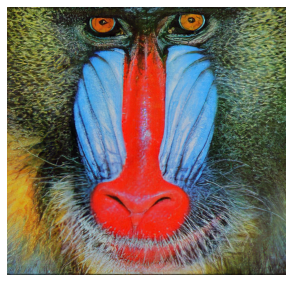

In [21]:
out_img=tensor2img(results)
out_img=cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(5, 5))
plt.imshow(out_img)
_ = plt.axis('off')